When encountering the term Autoencoder for the first time, one might wonder, Is it like an SVD with non-linear twists?. Autoencoders are neural networks designed to learn compact representations of data. Their architecture consists of an encoder (which compresses input data) and a decoder (which reconstructs the original data). The goal? To find a lower-dimensional representation (the “bottleneck”) that captures essential features. Singular Value Decomposition (SVD) is a mathematical technique that decomposes a matrix into three components: $U$ , $\Sigma$, and $V$. The matrix $\Sigma$ contains the singular values, which determine each component’s importance. 

SVD operates linearly—no fancy activation functions. Unlike the linear SVD, autoencoders embrace non-linearity. By using activation functions like ReLU or sigmoid, they capture complex relationships in the data.

 
$
\begin{array}{|l|l|}
\hline
\textbf{Application} & \textbf{SVD} & \textbf{Autoencoder} \\
\hline
\text{Data Compression} & \text{Compresses data by retaining significant singular values.} & \text{Reduces high-dimensional data into a manageable form.} \\
\hline
\text{Image Recognition} & \text{Used for face recognition and image compression.} & \text{Denoises corrupted data.} \\
\hline
\text{Collaborative Filtering} & \text{Uncovers latent factors in user-item interactions.} & \text{N/A} \\
\hline
\text{Dimensionality Reduction} & \text{N/A} & \text{Excels at dimensionality reduction.} \\
\hline
\text{Noise Reduction} & \text{N/A} & \text{Denoises data by learning robust representations.} \\
\hline
\text{Image Generation} & \text{N/A} & \text{VAEs create new data samples.} \\
\hline
\end{array}
$

In [23]:
##Credict Card froud detection using autoencoder

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import polars as pl
from torch.optim import lr_scheduler

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Binary Classification with an Autoencoder


The task of fraud detection for unsupervised data, particularly for credit card transactions, can be managed with a hybrid neural network approach. This can serve as an experimental case using data from a Kaggle dataset. The goal is to employ an autoencoder for binary classification, where the objective is to determine whether a transaction is fraudulent or not. The approach involves using the autoencoder to learn a latent representation and then applying a classifier on top of that representation.

In this case, the process should be as follows: Firts it whill train the Autoencoder for Feature Extraction using nn.MSELoss() to reconstruct the input data, then applied the Classifier for Binary Classification, were it will be utilized the features learned by the autoencoder (i.e., the encoded representation) as input to a separate classifier. This classifier, such as a neural network layer, should use nn.BCEWithLogitsLoss() for binary classification.

In [3]:
main_path = "credit_card/creditcard_2023.csv"

In [4]:
df = pd.read_csv(main_path)
#df = pl.read_csv(main_path)
df

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,568625,-0.833437,0.061886,-0.899794,0.904227,-1.002401,0.481454,-0.370393,0.189694,-0.938153,...,0.167503,0.419731,1.288249,-0.900861,0.560661,-0.006018,3.308968,0.081564,4394.16,1
568626,568626,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483894,...,0.031874,0.388161,-0.154257,-0.846452,-0.153443,1.961398,-1.528642,1.704306,4653.40,1
568627,568627,-0.311997,-0.004095,0.137526,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,...,0.140788,0.536523,-0.211100,-0.448909,0.540073,-0.755836,-0.487540,-0.268741,23572.85,1
568628,568628,0.636871,-0.516970,-0.300889,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893527,...,-0.060381,-0.195609,-0.175488,-0.554643,-0.099669,-1.434931,-0.159269,-0.076251,10160.83,1


In [31]:

# Normalize the "Amount" column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))


# Extract features and labels from the entire dataset
X = df.drop(["id", "Class"], axis=1).values  
y = df["Class"].values


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Filter non-fraudulent data (Class = 0) from the training set
X_train = X_train[y_train == 0]
y_train = y_train[y_train == 0]

# Display dimensions to verify
print("Dimensions of X_train_non_fraud:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train_non_fraud:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)

# #Standarize data based on mean & std of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train -mean)/std
X_test = (X_test -mean)/std

# Pass the data to tensors

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)  
y_test_tensor = torch.LongTensor(y_test)    


# Create DataLoader to handle data in batches
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


bs = 128
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=8)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=8)


Dimensions of X_train_non_fraud: (255816, 29)
Dimensions of X_test: (56863, 29)
Dimensions of y_train_non_fraud: (255816,)
Dimensions of y_test: (56863,)


## What is PCA?

PCA is a statistical procedure that transforms a dataset into a set of orthogonal (uncorrelated) components, called principal components. These components are ordered by the amount of variance they capture from the data. The first principal component captures the most variance, the second captures the second most, and so on.

Essentially I will going to project the high-dimensional data (before and after reconstruction) onto a lower-dimensional space for an easier interpretation. This can help in understanding how well the autoencoder is reconstructing the data by showing whether the reconstructed samples align with the original test samples in the reduced PCA space.

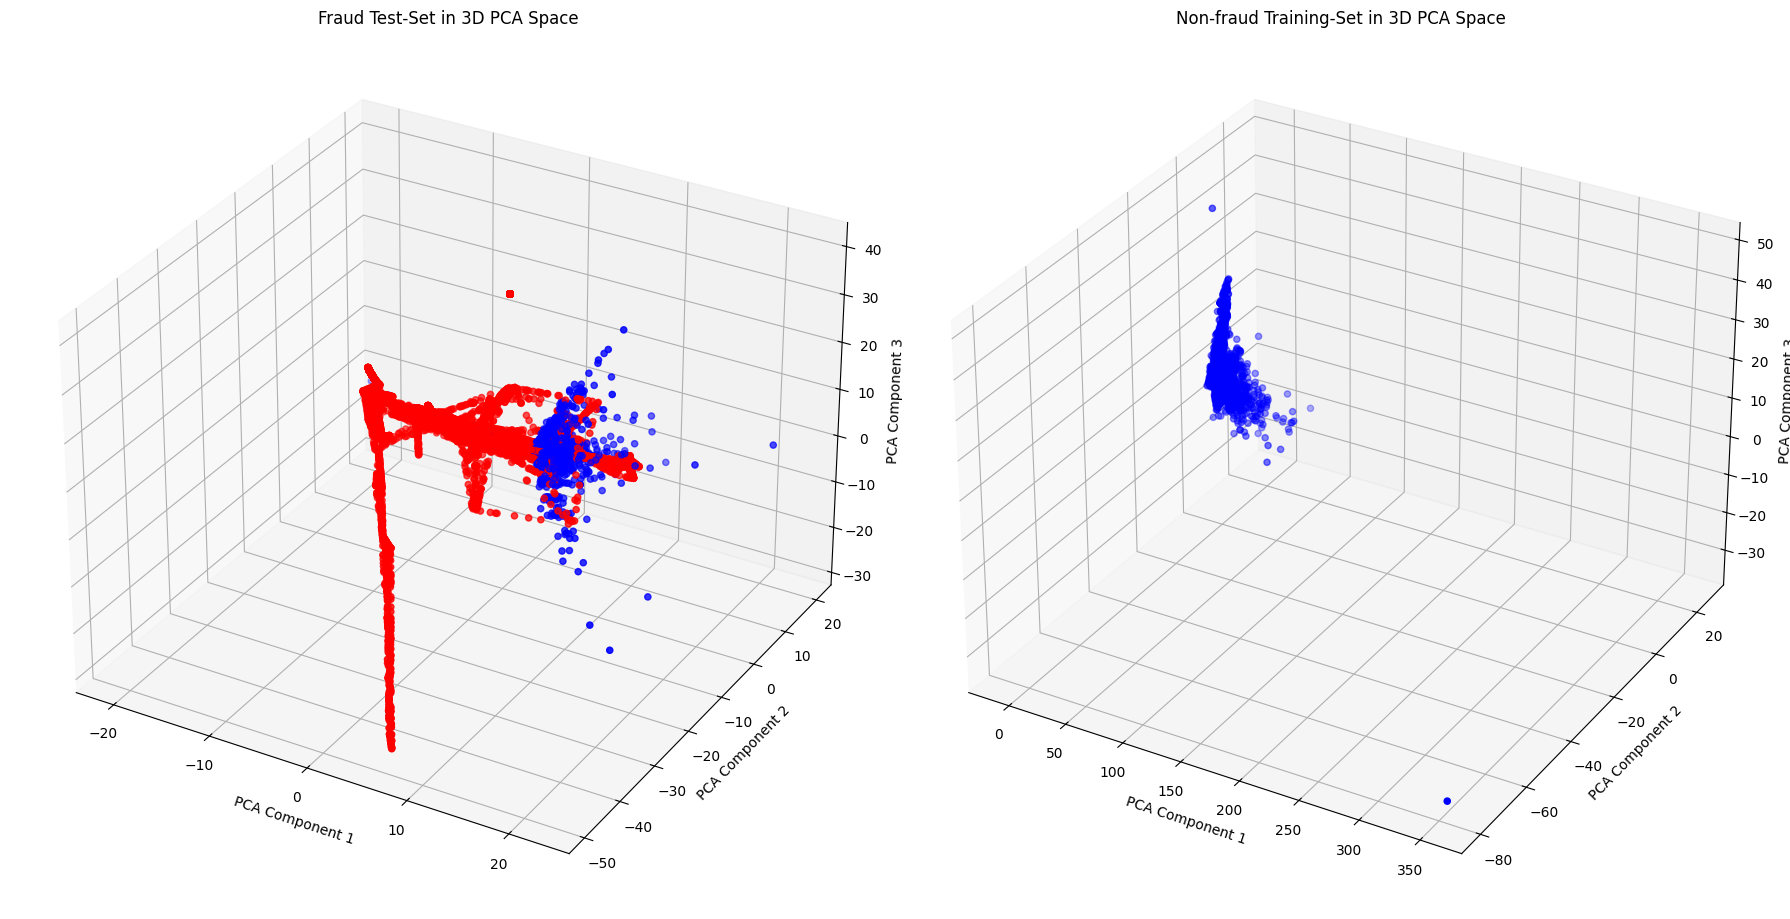

In [32]:
# Reducción dimensional a 3 componentes principales
pca = PCA(n_components=3)
X_test_reduced1 = pca.fit_transform(X_test)
X_test_reduced2 = pca.fit_transform(X_train)


# Colores para los puntos: 'r' para anomalías y 'b' para normales
colors_normal_train = ['r' if x == 1 else 'b' for x in y_test]

colors_test_train = ['r' if x == 1 else 'b' for x in y_train]

# Configuración de la figura y los ejes
fig = plt.figure(figsize=(18, 12))

# Primer gráfico
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_test_reduced1[:, 0], X_test_reduced1[:, 1], X_test_reduced1[:, 2],
                       c=colors_normal_train, marker='o')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('Fraud Test-Set in 3D PCA Space')

# Segundo gráfico
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_test_reduced2[:, 0], X_test_reduced2[:, 1], X_test_reduced2[:, 2],
                       c=colors_test_train, marker='o')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_zlabel('PCA Component 3')
ax2.set_title('Non-fraud Training-Set in 3D PCA Space')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [33]:
# ## Build the Autoencoder 

# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(29, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.Linear(16, 8),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(8, 16),
#             nn.ReLU(),
#             nn.Linear(16, 32),
#             nn.ReLU(),
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Linear(64, 29),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x


## Build the Autoencoder 

class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(29, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, latent_dim)  # Latent dimension
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 29),
            nn.Tanh()  # Changed from Sigmoid to Tanh for reconstruction
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class Classifier(nn.Module):
    def __init__(self, latent_dim):
        super(Classifier, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),  # Input dimension matches the latent space size
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1)  # Output layer for binary classification
        )
    
    def forward(self, x):
        x = self.classifier(x)
        return x  # Raw logits (not passed through sigmoid yet)


In [34]:
latent_dim = 64  # Choose from 8, 16, 32, 64, 128, etc.


autoencoder = Autoencoder(latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001,weight_decay=1e-5)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

avg_losses = []
# Training loop for autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0
    num_samples = 0

    for batch in train_loader:
        X_batch, _ = batch
        X_batch = X_batch.to(device)
        
        # Forward pass
        outputs = autoencoder(X_batch)
        loss = criterion(outputs, X_batch)
        
        # Backward and optimizez
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        train_loss += loss.item() * X_batch.size(0)
        num_samples += X_batch.size(0)

    avg_train_loss = train_loss / num_samples
    avg_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')



Epoch [1/100], Loss: 0.7887


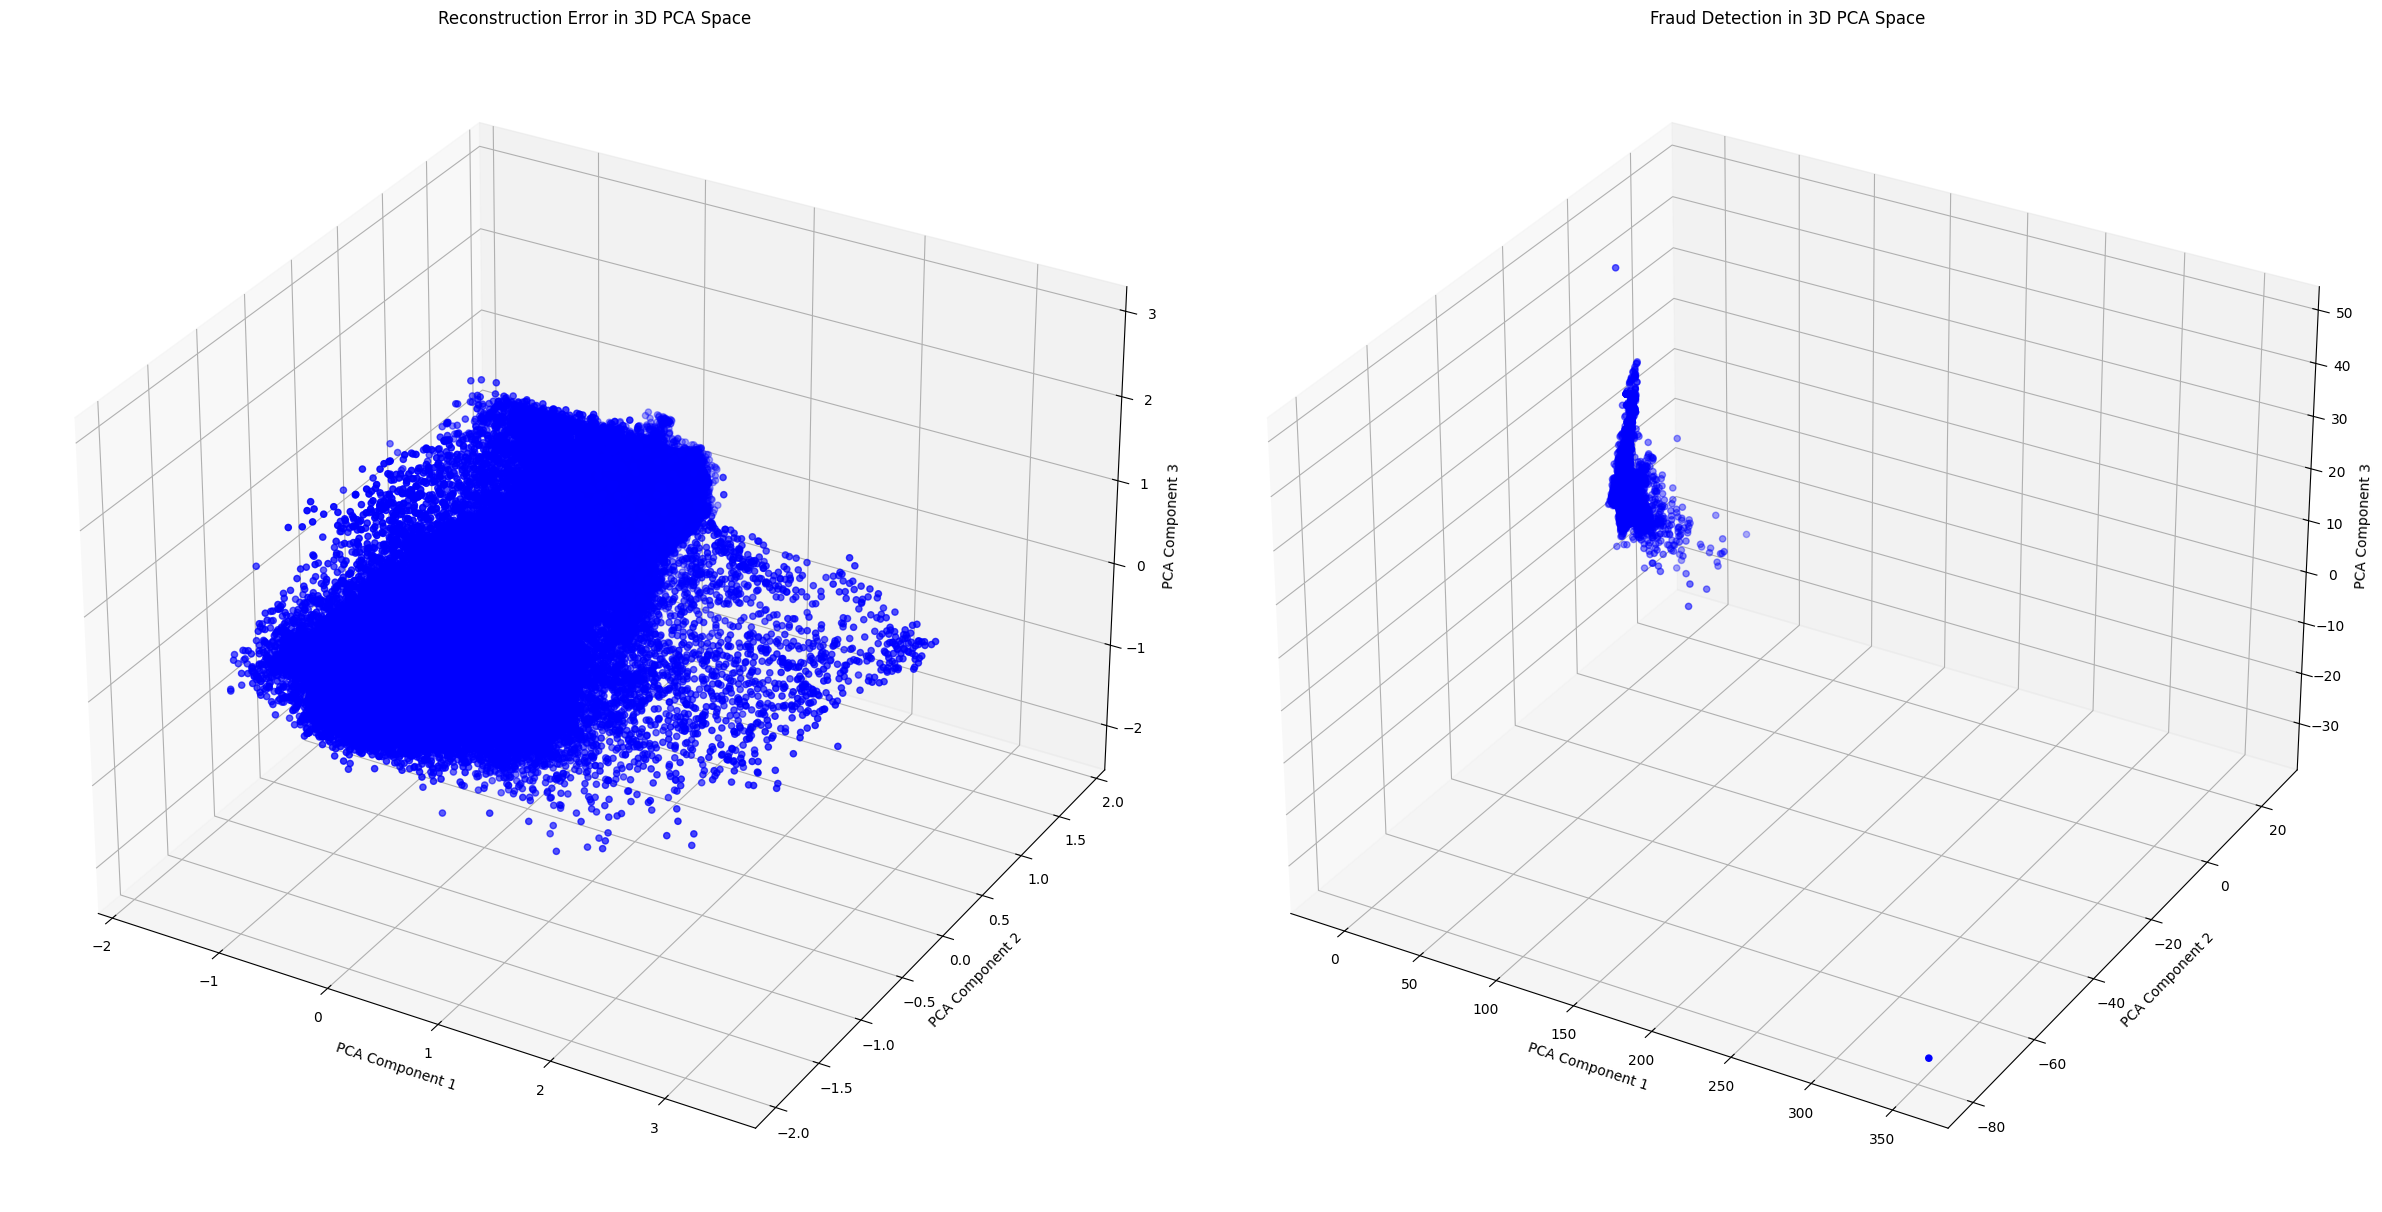

In [30]:
reconstructed_data = []

# Switch to evaluation mode
autoencoder.eval()

with torch.no_grad():  # No need to compute gradients for reconstruction
    for batch in train_loader:
        X_batch, _ = batch
        X_batch = X_batch.to(device)
        
        # Forward pass to get the reconstructed data
        outputs = autoencoder(X_batch)
        
        # Convert to CPU and add to the reconstructed data list
        reconstructed_data.append(outputs.cpu().numpy())

# Concatenate all batches to get the full reconstructed dataset
reconstructed_data = np.concatenate(reconstructed_data, axis=0)

# If the original dataset is required for comparison
original_data = []

for batch in train_loader:
    X_batch, _ = batch
    original_data.append(X_batch.cpu().numpy())

original_data = np.concatenate(original_data, axis=0)

# Convert to DataFrames 
original_df = pd.DataFrame(original_data)
reconstructed_df = pd.DataFrame(reconstructed_data)

# Dimensionality reduction to 3 principal components using PCA
pca = PCA(n_components=3)
original_data_reduced = pca.fit_transform(original_data)
reconstructed_data_reduced = pca.transform(reconstructed_data)

# Assuming you have `anomalies` and `y_test` defined
# Example placeholders
anomalies = torch.zeros(len(original_data))  # Replace with actual anomaly detection
y_test = np.zeros(len(original_data))        # Replace with actual labels for fraud detection

# Colors for the points: 'r' for anomalies and 'b' for normals
colors_anomalies = ['r' if x else 'b' for x in anomalies.cpu().numpy()]
colors_fraud = ['r' if x == 1 else 'b' for x in y_test]

# Configure the figure and axes
fig = plt.figure(figsize=(24, 12))

# First plot: Reconstruction Error
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(reconstructed_data_reduced[:, 0], reconstructed_data_reduced[:, 1], reconstructed_data_reduced[:, 2],
                       c=colors_anomalies, marker='o')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('Reconstruction Error in 3D PCA Space')

# Second plot: Fraud Detection
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(original_data_reduced[:, 0], original_data_reduced[:, 1], original_data_reduced[:, 2],
                       c=colors_fraud, marker='o')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_zlabel('PCA Component 3')
ax2.set_title('Fraud Detection in 3D PCA Space')

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
#Extract Features

autoencoder.eval()
features = []
labels = []

with torch.no_grad():
    for batch in train_loader:
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        feature = autoencoder.encoder(X_batch)
        features.append(feature.cpu())
        labels.append(y_batch.cpu())

features = torch.cat(features)
labels = torch.cat(labels)


In [ ]:

#Train the Classifier:


classifier = Classifier(latent_dim=latent_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001,weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.057)

# Training loop for classifier
num_epochs = 1
for epoch in range(num_epochs):
    classifier.train()
    train_loss = 0
    num_samples = 0

    for i in range(0, len(features), bs):
        feature_batch = features[i:i+bs].to(device)
        label_batch = labels[i:i+bs].to(device)
        
        # Forward pass
        logits = classifier(feature_batch)
        loss = criterion(logits.squeeze(), label_batch.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item() * feature_batch.size(0)
        num_samples += feature_batch.size(0)

    avg_train_loss = train_loss / num_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')


contador = [values for values in y_test if values==1]
len(contador)


Epoch [1/1], Loss: 0.6934


56976

In [13]:

#  reconstruction error on the training set
criterion = nn.MSELoss()

with torch.no_grad():
    X_train_tensor=X_train_tensor.to(device)
    reconstructions = autoencoder(X_train_tensor)

    train_loss = criterion(reconstructions, X_train_tensor)
print(f'Training accuracy: {(1-train_loss.item())*100:.4f}')
print(f'Training set loss: {(train_loss.item()):.4f}')

# threshold as a multiple of the training set loss
threshold = train_loss.item() * 1.25
print(f'Set threshold: {threshold:.4f}')


Training accuracy: 48.8508
Training set loss: 0.5115
Set threshold: 0.6394


In [15]:
contador = [values for values in y_test if values==1]
len(contador)

# Detect anomalies on the test set
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    reconstructions = autoencoder(X_test_tensor)
    test_loss = torch.mean((reconstructions - X_test_tensor) ** 2, dim=1)

anomalies = test_loss > threshold
anomaly_indices = np.where(anomalies.cpu().numpy())[0]

print(f'Number of anomalies detected: {len(anomaly_indices)} vs Numger of anomalies: {len(contador)}')

from sklearn.metrics import precision_score, recall_score, f1_score

# Create a list of predictions (1 for anomaly, 0 for normal)
y_pred = np.zeros_like(y_test)
y_pred[anomaly_indices] = 1

# Evaluate the system
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Number of anomalies detected: 29221 vs Numger of anomalies: 28364
Precision: 0.8753
Recall: 0.9017
F1 Score: 0.8883


In [29]:
from sklearn.ensemble import IsolationForest

# Entrena el modelo Isolation Forest
isolation_forest = IsolationForest(contamination=0.01)  # Ajusta el parámetro de contaminación según sea necesario
isolation_forest.fit(X_test)

# Predicciones: -1 para anomalías, 1 para normales
predictions = isolation_forest.predict(X_test)

# Convertir las predicciones a 0 para normales y 1 para anomalías
anomalies = (predictions == -1).astype(int)

# Evaluar el sistema
precision = precision_score(y_test, anomalies)
recall = recall_score(y_test, anomalies)
f1 = f1_score(y_test, anomalies)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.9156
Recall: 0.0184
F1 Score: 0.0360


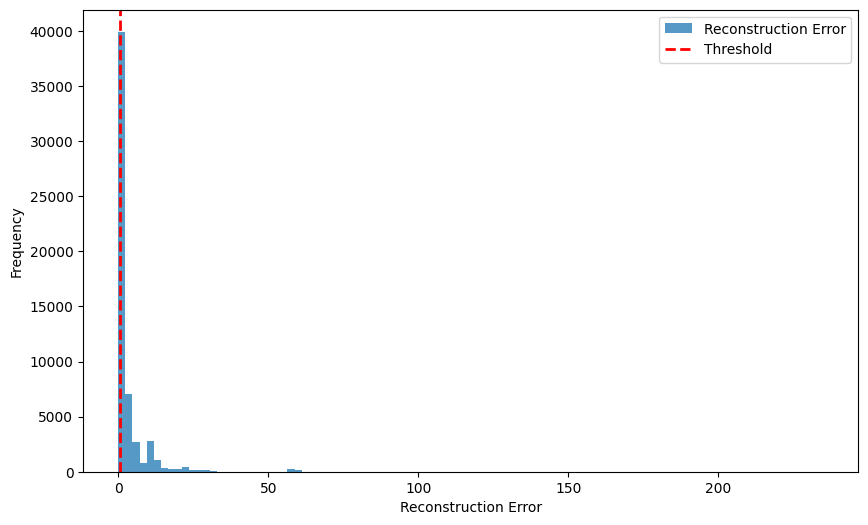

In [16]:
# Plot reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(test_loss.cpu().numpy(), bins=100, alpha=0.75, label='Reconstruction Error')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set the model to evaluation mode
autoencoder.eval()

# Compute reconstruction errors for the test set
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    reconstructions = autoencoder(X_test_tensor)
    
    # Calculate reconstruction loss for each sample
    reconstruction_errors = torch.mean((reconstructions - X_test_tensor) ** 2, dim=1).cpu().numpy()

# Convert true labels to numpy array
y_true = y_test_tensor.cpu().numpy()

Set threshold: 0.6394


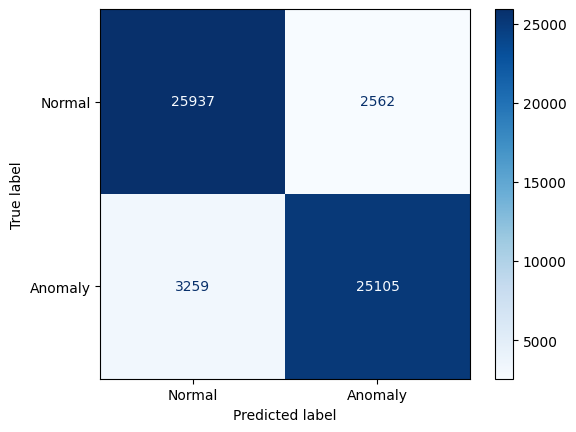

In [19]:
# Recycle code from above
print(f'Set threshold: {threshold:.4f}')

# Create binary labels based on the threshold
y_pred = (reconstruction_errors > threshold).astype(int)

# Convert true labels to binary if necessary
# '1' represents anomaly
y_true_binary = (y_true == 1).astype(int)  

# Compute confusion matrix
cm = confusion_matrix(y_true_binary, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues', values_format='d')

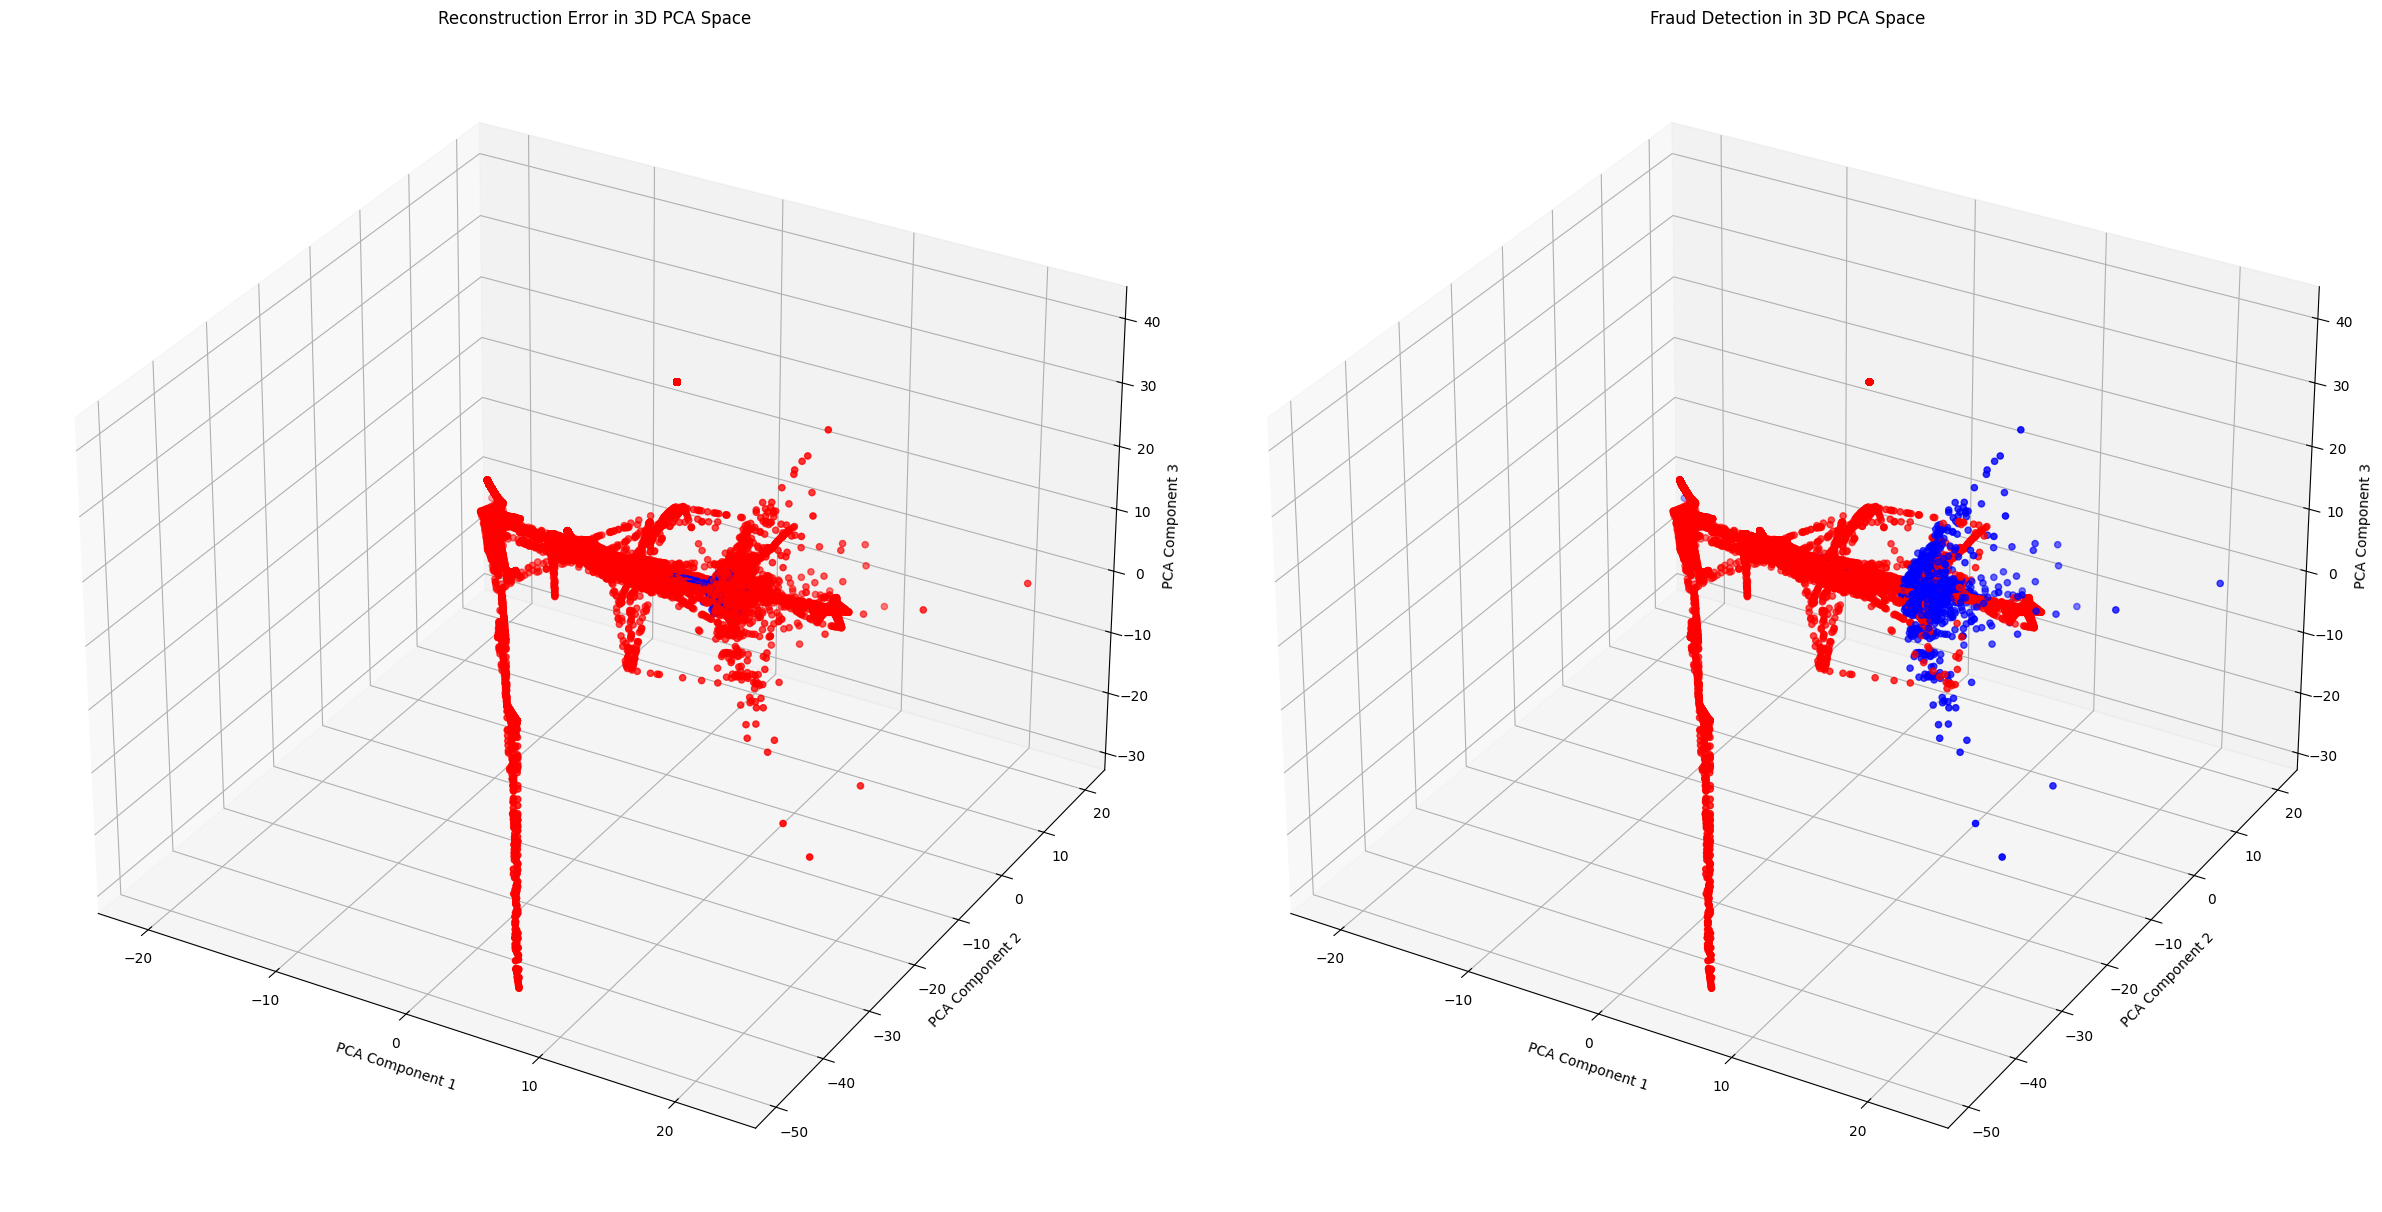

In [20]:


# Reducción dimensional a 3 componentes principales
pca = PCA(n_components=3)
X_test_reduced = pca.fit_transform(X_test)

# Colores para los puntos: 'r' para anomalías y 'b' para normales
colors_anomalies = ['r' if x else 'b' for x in anomalies.cpu().numpy()]
colors_fraud = ['r' if x == 1 else 'b' for x in y_test]

# Configuración de la figura y los ejes
fig = plt.figure(figsize=(24, 12))

# Primer gráfico: Reconstrucción de error
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], X_test_reduced[:, 2],
                       c=colors_anomalies, marker='o')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('Reconstruction Error in 3D PCA Space')

# Segundo gráfico: Detección de fraude
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], X_test_reduced[:, 2],
                       c=colors_fraud, marker='o')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_zlabel('PCA Component 3')
ax2.set_title('Fraud Detection in 3D PCA Space')

# Mostrar las gráficas
plt.tight_layout()
plt.show()
